### Model Building & Evaluation

In [ ]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [ ]:
pre_process_df = pd.read_csv('pre_processed_train.csv')
pre_process_df_test =  pd.read_csv('pre_process_df_test.csv')

In [ ]:
feat_df = pd.read_csv('feat_df_train.csv')
feat_df_test = pd.read_csv('feat_df_test.csv')

In [ ]:
unwanted_columns = ['HomePlanet', 'CryoSleep', 'Destination','VIP','Cabin_deck','Cabin_starboard','Passenger_group']

# Function to Scale the data and Prepare Trainning and Test data
def get_data_for_trainning(df,test_size=0.2):
  scaler = StandardScaler()
  X = df.drop(columns=['Transported'])
  y = df['Transported']
  df_scaled = scaler.fit_transform(X)
  df_scaled = pd.DataFrame(df_scaled,columns=X.columns,index=X.index)
  X_train, X_test, y_train, y_test = train_test_split(df_scaled, y, test_size=test_size, random_state=42)
  return X_train, X_test, y_train, y_test,scaler

#Function to Test the Models
def train_models(X_train,X_test,y_train,y_test):
  models = {
      'Logistic Regression': LogisticRegression(),
      'Naive Bayes': GaussianNB(),
      'Support Vector Machine': SVC(),
      'K-Nearest Neighbors': KNeighborsClassifier(),
      'Decision Tree': DecisionTreeClassifier(),
      'Random Forest': RandomForestClassifier(random_state=42),
      'XGBoost': xgb.XGBClassifier(eval_metric='logloss')
  }


  metrics_df = pd.DataFrame(columns=['Model', 'Accuracy'])
  trained_models = {}
  classification_reports = {}


  for name, model in models.items():
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      accuracy = accuracy_score(y_test, y_pred)
      report = classification_report(y_test, y_pred)
      classification_reports[name] = report
      trained_models[name] = model
      new_row = pd.DataFrame({'Model': [name], 'Accuracy': [accuracy]})
      metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

      # print(f'Model: {name}')
      # print(f'Accuracy: {accuracy}\n')

  return trained_models,metrics_df, classification_reports

#Function to Plot the Confusion Matrix
def plot_confusion_matrix(model, X_test, y_test):
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Plot confusion matrix as heatmap
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def plot_roc_curve(model, X_test, y_test):
    # Plot ROC curve
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def print_classification_report(y_test, y_pred):
    print("Classification Report:\n", classification_report(y_test, y_pred))

def generate_predictions(model,df,scaler,label_encoder):
  x = df.drop(columns=['PassengerId'])
  x_scaled = scaler.transform(x)
  x = pd.DataFrame(x_scaled,columns=x.columns,index=x.index)
  preds = model.predict(x)
  df['Transported'] = label_encoder.inverse_transform(preds)
  return df

#### Trainning on Data without Feature engineering

In [ ]:
df = pre_process_df.drop(columns=unwanted_columns)
X_train, X_test, y_train, y_test,scaler_without_fe = get_data_for_trainning(df)
trained_models_without_fe,metrics_df,classification_reports = train_models(X_train, X_test, y_train, y_test)
metrics_df.sort_values(by='Accuracy',ascending=False)

,Model,Accuracy
5,Random Forest,0.797585
6,XGBoost,0.795285
2,Support Vector Machine,0.791259
0,Logistic Regression,0.782059
3,K-Nearest Neighbors,0.778033
4,Decision Tree,0.756182
1,Naive Bayes,0.746406


In [ ]:
rf = trained_models_without_fe['Random Forest'] ##Selected the Best Model
df = pre_process_df_test.drop(columns=unwanted_columns)
df = generate_predictions(rf,df,scaler_without_fe,label_encoder)
df[['PassengerId','Transported']].to_csv('preds1.csv',index=False)

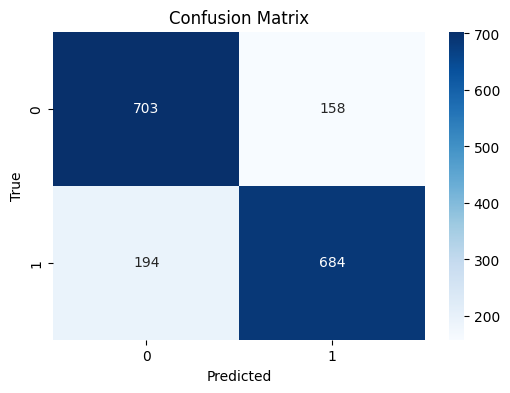

In [ ]:
plot_confusion_matrix(rf, X_test, y_test)

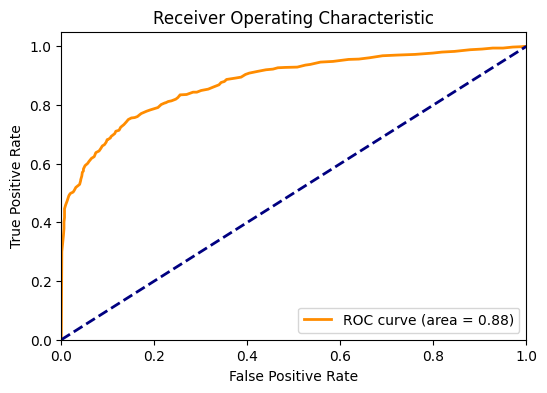

In [ ]:
plot_roc_curve(rf, X_test, y_test)

In [ ]:
print (classification_reports['Random Forest'])

              precision    recall  f1-score   support

           0       0.78      0.82      0.80       861
           1       0.81      0.78      0.80       878

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739




#### Trainning on Data with Feature engineering

In [ ]:
df = feat_df.drop(columns=unwanted_columns)
X_train, X_test, y_train, y_test,scaler_with_fe = get_data_for_trainning(df)
trained_models_with_fe,metrics_df,classification_reports = train_models(X_train, X_test, y_train, y_test)
metrics_df.sort_values(by='Accuracy',ascending=False)

,Model,Accuracy
6,XGBoost,0.801035
2,Support Vector Machine,0.793560
5,Random Forest,0.787234
0,Logistic Regression,0.786084
3,K-Nearest Neighbors,0.769408
1,Naive Bayes,0.753882
4,Decision Tree,0.732605


In [ ]:
xgboost = trained_models_with_fe['XGBoost']#selected the best model
df = feat_df_test.drop(columns=unwanted_columns)
df = generate_predictions(xgboost,df,scaler_with_fe,label_encoder)
df[['PassengerId','Transported']].to_csv('preds2.csv',index=False)

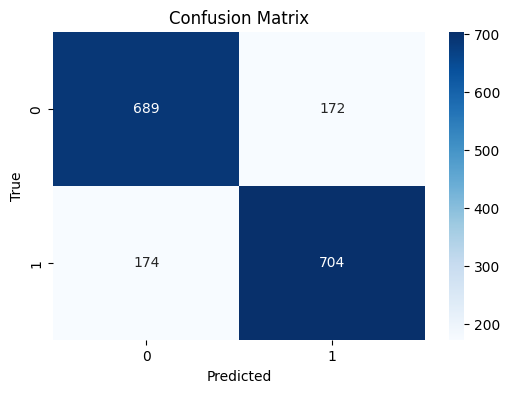

In [ ]:
plot_confusion_matrix(xgboost, X_test, y_test)

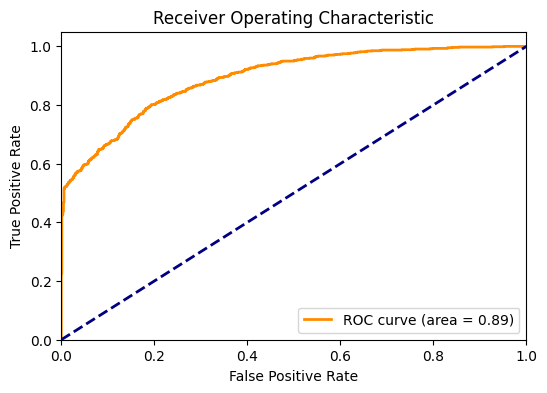

In [ ]:
plot_roc_curve(xgboost, X_test, y_test)

In [ ]:
print (classification_reports['XGBoost'])

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       861
           1       0.80      0.80      0.80       878

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



In [ ]:
xgboost.save_model('xgboost_model.json')